In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.signal.windows import hamming, bartlett, blackman, kaiser, hann
from scipy.fft import fft
from prettytable import PrettyTable
import seaborn as sns
import pandas as pd


In [3]:
#hàm load file audio
def load_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        return audio, sr
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None, None

def compute_ste(audio,frame_length,hop_length):
    """Compute Shore-Time Energy (STE) for each frame."""
    # framed_audio = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)
    # ste = np.sum(np.square(framed_audio), axis=0)

    num_frames = 1 + int((len(audio) - frame_length) / hop_length)
    ste = np.zeros(num_frames)

    for i in range(num_frames):
        start = i * hop_length
        end = start + frame_length
        # Lấy frame
        frame = audio[start:end]
        # Tính toán năng lượng (STE) cho frame
        ste[i] = np.sum(frame ** 2)
    # chuẩn hóa
    ste /= np.max(ste)

    return ste





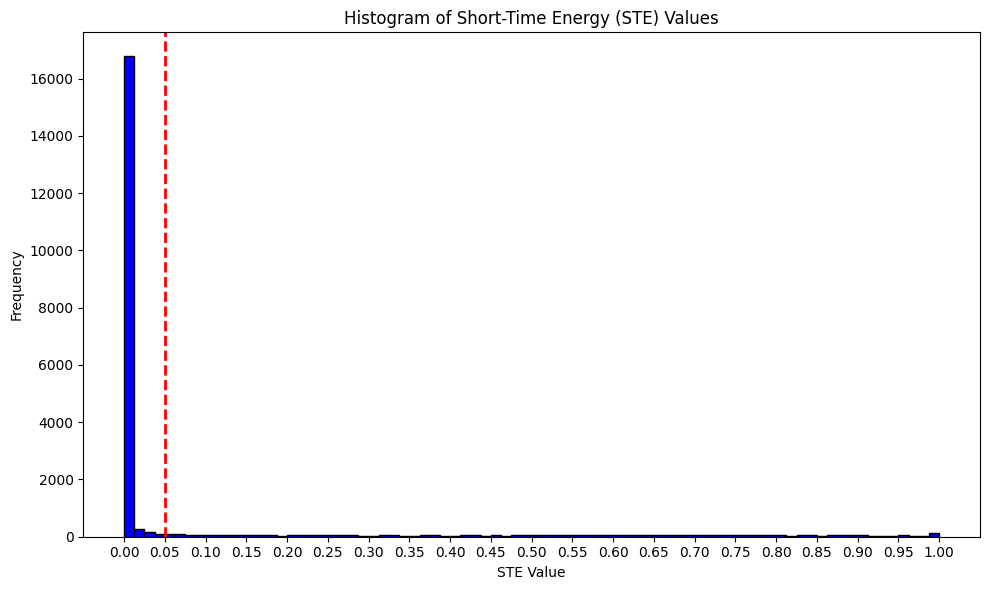

In [4]:
file_path = './signals/NguyenAmHuanLuyen-16k/27MCM/i.wav'  # Replace with the actual path to your audio file

FRAME_SIZE = 0.02
FRAME_SHIFT = 0.01

audio, sr = load_audio(file_path)
max_amplitude = np.max(np.abs(audio))
normalized_audio = audio / max_amplitude

framesize = int(FRAME_SIZE * sr)  # 30 ms window
frameshift = int(FRAME_SHIFT * sr)  # 10 ms hop

# Compute STE for each frame
ste = compute_ste(audio,framesize,frameshift)

signals = [
    '23MTL', '24FTL', '25MLM', '27MCM', '28MVN',
    '29MHN', '30FTN', '32MTP', '33MHP', '34MQP',
    '35MMQ', '36MAQ', '37MDS', '38MDS', '39MTS',
    '40MHS', '41MVS', '42FQT', '43MNT', '44MTT', '45MDV'
]
vowels = ['a', 'e', 'i', 'o', 'u']
path_prefix = 'signals/NguyenAmHuanLuyen-16k/'
ste_values = np.array([])

# Calculate STE values
for signal in signals:
    for vowel in vowels:
        filename = path_prefix + signal + '/' + vowel + '.wav'
        y, Fs = librosa.load(filename)
        ste_values = np.concatenate((ste_values, compute_ste(y,framesize,frameshift)))

# Plot Histogram
plt.figure(figsize=(10, 6))
plt.hist(ste_values, bins=80, color='blue', edgecolor='black')
plt.title('Histogram of Short-Time Energy (STE) Values')
plt.xlabel('STE Value')
plt.ylabel('Frequency')

# Add a vertical line at the median value
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=2)

# Set x-axis ticks at regular intervals from 0.01 to a specific maximum value
tick_interval = 0.05
plt.xticks(np.arange(0.0, 1.0+tick_interval, tick_interval))

plt.tight_layout()  # Optimize display of the plot
plt.show()

0.05


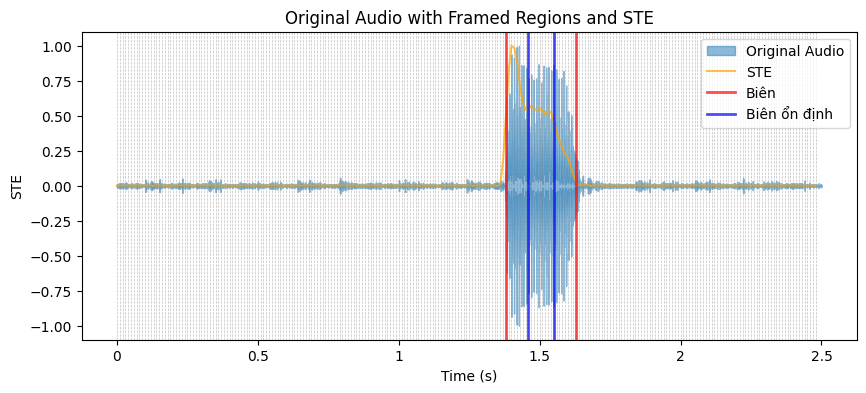

In [8]:
plt.figure(figsize=(10, 4))
# Plot the original audio
librosa.display.waveshow(normalized_audio, sr=sr, alpha=0.5, label='Original Audio')
for frame_start in range(0, len(ste) * frameshift, frameshift):
    plt.axvline(x=frame_start / sr, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Plot the STE on the same y-axis with a different color
plt.plot(np.arange(ste.shape[0]) * frameshift / sr, ste, color='orange', label='STE', alpha=0.7)
#Compute threshold
threshold = 0.05
print(threshold)
# Iterate through each frame forward
for i in range(len(ste)):
    # Check if STE for the current frame is greater than the threshold
    if ste[i] > threshold :
        # Plot a vertical red line at the corresponding time
        plt.axvline(x=(i * frameshift + framesize / 2) / sr, color='red', linestyle='-', linewidth=2, alpha=0.7, label='Biên')
        left_border = i
        break

# Iterate through each frame backward
for i in range(len(ste) - 1, -1, -1):
    # Check if STE for the current frame is greater than the threshold
    if ste[i] > threshold :
        # Plot a vertical red line at the corresponding time
        plt.axvline(x=(i * frameshift + framesize / 2) / sr, color='red', linestyle='-', linewidth=2, alpha=0.7)
        right_border = i
        break

left_stable_border = left_border + (right_border - left_border)//3
right_stable_border = right_border - (right_border - left_border)//3

left_sample = int(left_stable_border * frameshift)  
right_sample = int(right_stable_border * frameshift)

stable_region = audio[left_sample:right_sample]
    
plt.axvline(x=(left_stable_border * frameshift + framesize / 2) / sr, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Biên ổn định')
plt.axvline(x=(right_stable_border * frameshift + framesize / 2) / sr, color='blue', linestyle='-', linewidth=2, alpha=0.7)




# Set the labels and title
plt.title('Original Audio with Framed Regions and STE')
plt.xlabel('Time (s)')
plt.ylabel('STE')

# Create a legend for the plot
plt.legend()

plt.show()


In [9]:
def extract_feature_vector(speaker, vowel, FFT_POINTS,frame_mode,window_function):
    """Extract the feature vector of 1 speaker with 1 vowel"""
    # Define the file path based on the speaker and vowel
    file_path = f'signals/{speaker}/{vowel}.wav'
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Define framesize and frameshift
    framesize = int(frame_mode[0] * sr)  # 30 ms window
    frameshift = int(frame_mode[1] * sr)  # 10 ms hop

    # Frame the audio signal

    # Compute Short-Time Energy (STE) for each frame
    ste = compute_ste(audio,framesize,frameshift)
    # Set the threshold
    threshold = np.mean(ste)

    # Find the stable region
    left_border, right_border = None, None
    for i in range(len(ste)):
        if ste[i] > threshold:
            left_border = i
            break

    for i in range(len(ste) - 1, -1, -1):
        if ste[i] > threshold:
            right_border = i
            break

    # Calculate the time coordinates of the stable region
    left_stable_border = left_border + (right_border - left_border)*0 // 3
    right_stable_border = right_border - (right_border - left_border)*0 // 3

    left_stable_sample = int(left_stable_border * frameshift)  # Assuming frameshift is in samples
    right_stable_sample = int(right_stable_border * frameshift)

    # left_sample = int(left_border * frameshift)  # Assuming frameshift is in samples
    # right_sample = int(right_border * frameshift)

    stable_region = audio[left_stable_sample:right_stable_sample]
    fft_vector = extract_vectorFFT(stable_region, sr, FFT_POINTS,frame_mode,window_function)
    return fft_vector

def compute_average_feature_vector(speakers, vowel, FFT_POINTS,frame_mode,window_function):
    """Compute the average feature vector for a given vowel across multiple speakers."""
    # Initialize an empty array to store individual feature vectors
    all_feature_vectors = []

    # Compute feature vectors for each speaker
    for speaker in speakers:
        feature_vector = extract_feature_vector(speaker, vowel, FFT_POINTS,frame_mode,window_function)
        all_feature_vectors.append(feature_vector)

    average_feature_vector = np.average(all_feature_vectors, axis=0, weights=np.arange(len(speakers)))

    return average_feature_vector

def extract_vectorFFT(y, sr, FFT_POINTS,frame_mode,window_function):
    frame_shift = int(frame_mode[1] * sr)
    frame_len = int(frame_mode[0] * sr)
    frame_num = (len(y) - frame_len) // frame_shift + 1

    fft_vector = []  # Use a Python list to store individual FFT vectors
    #chọn chế độ cửa sổ
    if window_function=='hamming':
        hm = hamming(frame_len)
    elif window_function=='bartlett':
        hm = bartlett(frame_len)
    elif window_function=='blackman':
        hm = blackman(frame_len)
    elif window_function=='kaiser':
        hm = kaiser(frame_len, 14)
    elif window_function=='hann':
        hm = hann(frame_len)

    for i in range(frame_num):
        start = i * frame_shift
        finish = start + frame_len
        frame = y[start:finish]
        yy = frame * hm
        fft_vector.append(np.abs(fft(yy, n=FFT_POINTS)))

    fft_array = np.array(fft_vector)
    normalized_array = fft_array / np.max(np.abs(fft_array))
    vector_mean = np.mean(normalized_array, axis=0).reshape(-1, 1)
    return vector_mean


def euclidean_distance(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Two vectors must have the same length.")

    # Tính toán khoảng cách Euclidean
    distance = np.sqrt(np.sum((vector1 - vector2)**2))
    
    return distance

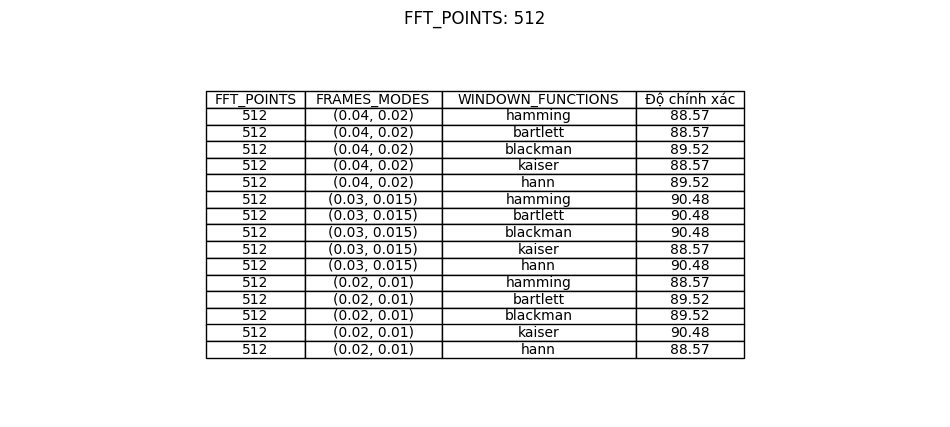

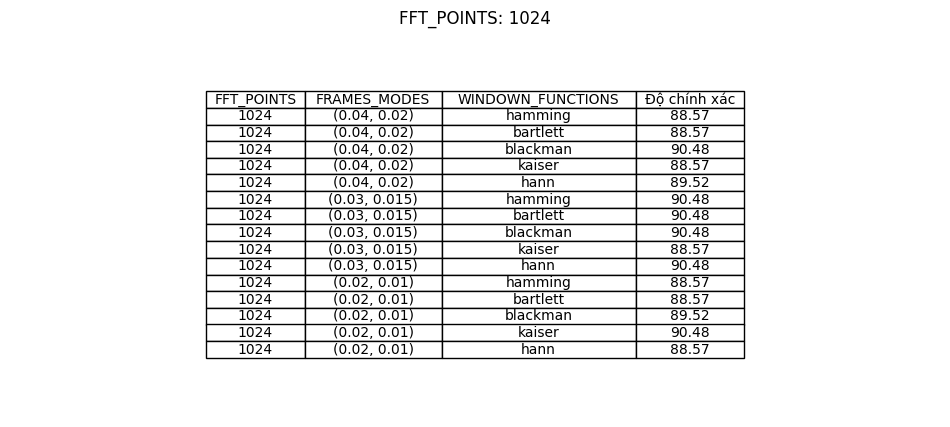

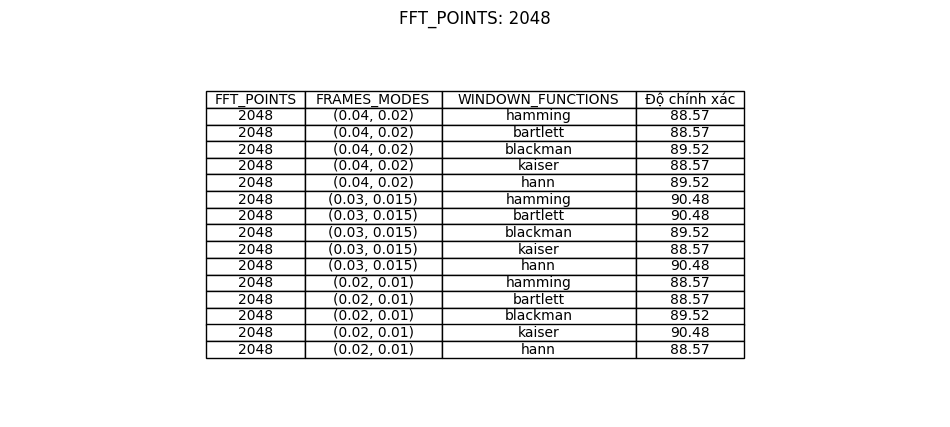

Kết quả tốt nhất
N_FFT= 512 
 Frame_Size= 0.03 s
 Frame_Shift= 0.015 s
Window function: hamming 
Độ chính xác: 90.48 %


In [10]:
# Tập huấn luyện
training_speakers = [
    'NguyenAmHuanLuyen-16k/45MDV',
    'NguyenAmHuanLuyen-16k/23MTL',
    'NguyenAmHuanLuyen-16k/24FTL',
    'NguyenAmHuanLuyen-16k/25MLM',
    'NguyenAmHuanLuyen-16k/27MCM',
    'NguyenAmHuanLuyen-16k/28MVN',
    'NguyenAmHuanLuyen-16k/29MHN',
    'NguyenAmHuanLuyen-16k/30FTN',
    'NguyenAmHuanLuyen-16k/32MTP',
    'NguyenAmHuanLuyen-16k/33MHP',
    'NguyenAmHuanLuyen-16k/34MQP',
    'NguyenAmHuanLuyen-16k/35MMQ',
    'NguyenAmHuanLuyen-16k/36MAQ',
    'NguyenAmHuanLuyen-16k/37MDS',
    'NguyenAmHuanLuyen-16k/38MDS',
    'NguyenAmHuanLuyen-16k/39MTS',
    'NguyenAmHuanLuyen-16k/40MHS',
    'NguyenAmHuanLuyen-16k/41MVS',
    'NguyenAmHuanLuyen-16k/42FQT',
    'NguyenAmHuanLuyen-16k/43MNT',
    'NguyenAmHuanLuyen-16k/44MTT']

# danh sách các nguyên âm
vowel_list = ['a', 'e', 'i', 'o', 'u']

test_folder_path = 'NguyenAmKiemThu-16k/'
# Tập kiểm thử
speakers_list = [
    '01MDA',
    '02FVA',
    '03MAB',
    '04MHB',
    '05MVB',
    '06FTB',
    '07FTC',
    '08MLD',
    '09MPD',
    '10MSD',
    '11MVD',
    '12FTD',
    '14FHH',
    '15MMH',
    '16FTH',
    '17MTH',
    '18MNK',
    '19MXK',
    '20MVK',
    '21MTL',
    '22MHL']

def solve_prob2(FFT_POINTS, frame_mode, window_function):
    vowel_average_vector = dict()
    vowel_average_vector['a'] = compute_average_feature_vector(training_speakers, 'a', FFT_POINTS, frame_mode,
                                                               window_function)
    vowel_average_vector['e'] = compute_average_feature_vector(training_speakers, 'e', FFT_POINTS, frame_mode,
                                                               window_function)
    vowel_average_vector['i'] = compute_average_feature_vector(training_speakers, 'i', FFT_POINTS, frame_mode,
                                                               window_function)
    vowel_average_vector['o'] = compute_average_feature_vector(training_speakers, 'o', FFT_POINTS, frame_mode,
                                                               window_function)
    vowel_average_vector['u'] = compute_average_feature_vector(training_speakers, 'u', FFT_POINTS, frame_mode,
                                                               window_function)
    # tạo ma trận nhầm lẫn
    confusion_matrix = {
        'a': {'a': 0, 'e': 0, 'i': 0, 'o': 0, 'u': 0},
        'e': {'a': 0, 'e': 0, 'i': 0, 'o': 0, 'u': 0},
        'i': {'a': 0, 'e': 0, 'i': 0, 'o': 0, 'u': 0},
        'o': {'a': 0, 'e': 0, 'i': 0, 'o': 0, 'u': 0},
        'u': {'a': 0, 'e': 0, 'i': 0, 'o': 0, 'u': 0}
    }
    validation_matrix = defaultdict(lambda: defaultdict(lambda: False))
    for speaker in speakers_list:

        for vowel in vowel_list:
            distance = {}
            speaker_feature_vector = extract_feature_vector(test_folder_path + speaker, vowel, FFT_POINTS, frame_mode,
                                                            window_function)

            distance['a'] = euclidean_distance(speaker_feature_vector, vowel_average_vector['a'])
            distance['e'] = euclidean_distance(speaker_feature_vector, vowel_average_vector['e'])
            distance['i'] = euclidean_distance(speaker_feature_vector, vowel_average_vector['i'])
            distance['o'] = euclidean_distance(speaker_feature_vector, vowel_average_vector['o'])
            distance['u'] = euclidean_distance(speaker_feature_vector, vowel_average_vector['u'])

            min_distance = min(distance.values())
            predicted_vowel = ""
            if min_distance == distance['a']:
                confusion_matrix[vowel]['a'] += 1
                predicted_vowel = 'a'
            elif min_distance == distance['e']:
                confusion_matrix[vowel]['e'] += 1
                predicted_vowel = 'e'
            elif min_distance == distance['i']:
                confusion_matrix[vowel]['i'] += 1
                predicted_vowel = 'i'
            elif min_distance == distance['o']:
                confusion_matrix[vowel]['o'] += 1
                predicted_vowel = 'o'
            else:
                confusion_matrix[vowel]['u'] += 1
                predicted_vowel = 'u'
            validation_matrix[speaker[-5:]][vowel] = 1 if vowel == predicted_vowel else 0

        correct = 0
        total = 0
        for vowel in vowel_list:
            total += sum(confusion_matrix[vowel].values())
            correct += confusion_matrix[vowel][vowel]
    return (vowel_average_vector, confusion_matrix, round(correct / total * 100, ndigits=2), validation_matrix)


FFT_POINTS = [512, 1024, 2048]
FRAMES_MODES = [(0.04, 0.02), (0.03, 0.015), (0.02, 0.01)]
WINDOWN_FUNCTIONS = ['hamming', 'bartlett', 'blackman', 'kaiser', 'hann']

maximum_case = [0]
for fft_point in FFT_POINTS:
    data = []

    for frame_mode in FRAMES_MODES:
        for window_function in WINDOWN_FUNCTIONS:
            vowel_average_vector, confusion_matrix, accuracy,validation_matrix = solve_prob2(fft_point, frame_mode, window_function)
            if accuracy > maximum_case[0]:
                maximum_case = [accuracy, vowel_average_vector, confusion_matrix,
                                (fft_point,frame_mode,window_function),validation_matrix ]
            data.append([fft_point, frame_mode, window_function, accuracy])

    df = pd.DataFrame(data, columns=["FFT_POINTS", "FRAMES_MODES", "WINDOWN_FUNCTIONS", "Độ chính xác"])

        # Tạo và hiển thị bảng sử dụng matplotlib
    fig, ax = plt.subplots(figsize=(12, 5))  # Điều chỉnh kích thước bảng theo ý muốn

    ax.axis('off')

    ax.set_title(f"FFT_POINTS: {fft_point}")  # Tiêu đề của bảng

    table = ax.table(cellText=df.values,
                        colLabels=df.columns,
                        loc='center',
                        cellLoc='center')

    # Điều chỉnh kích cỡ font, chiều rộng cột cho phù hợp
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.show()

[ accuracy, vowel_average_vector, confusion_matrix, case,validation_matrix] = maximum_case
# case = [FFT_POINTS[0],FRAMES_MODES[2],WINDOWN_FUNCTIONS[3]]
# vowel_average_vector,confusion_matrix,accuracy,validation_matrix = solve_prob2(case[0], case[1], case[2])
print("Kết quả tốt nhất")
print( "N_FFT=",case[0],'\n',
       'Frame_Size=',case[1][0],'s\n',
       'Frame_Shift=',case[1][1],'s\n'
       "Window function:",case[2],'\n'
       "Độ chính xác:", accuracy, "%")


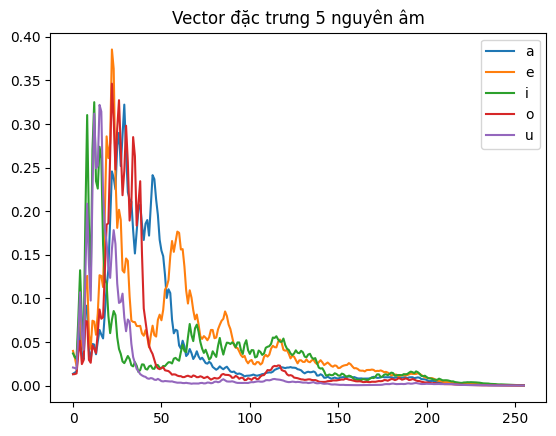

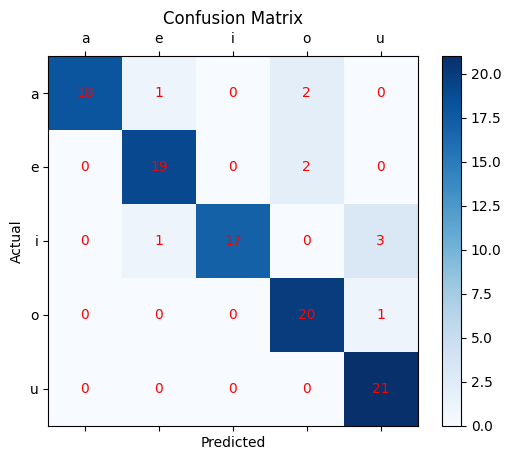

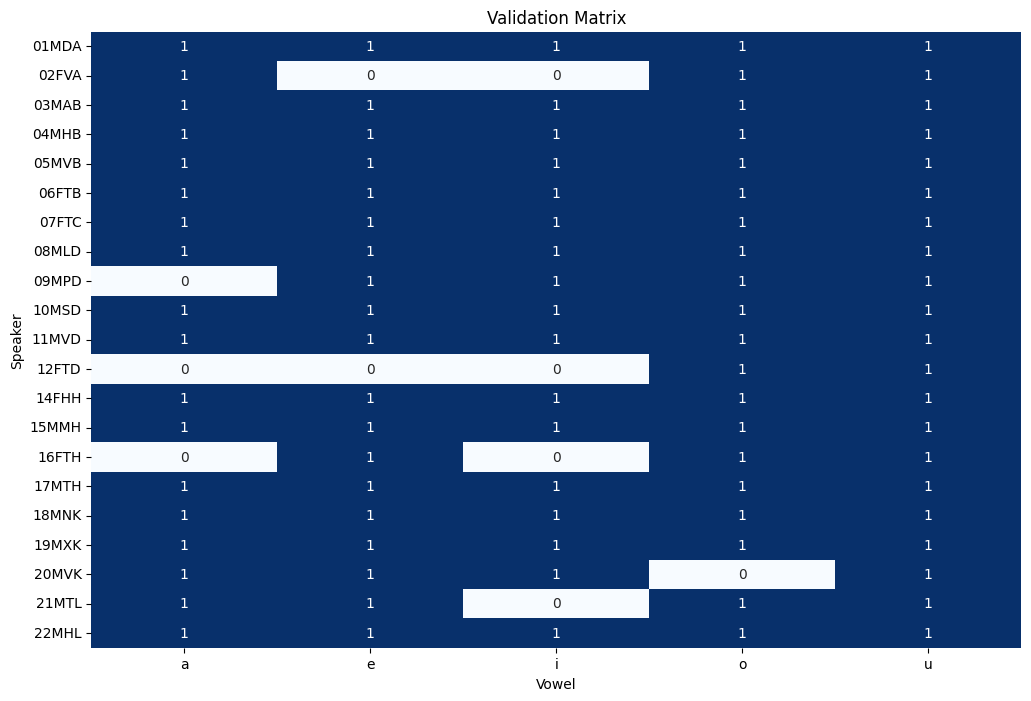

In [11]:
# vẽ các vector đặc trưng nguyên âm
plt.figure()
plt.title("Vector đặc trưng 5 nguyên âm")
for vowel in vowel_list:
    # vẽ vector đặc trưng của người nói
    plt.plot(vowel_average_vector[vowel][:len(vowel_average_vector[vowel]) // 2],
             label=vowel)  # Plot and label feature vector

    plt.legend()
plt.show()

# Chuyển dictionary thành một ma trận numpy để sử dụng plt.imshow
matrix_values = np.array([[confusion_matrix[i][j] for j in 'aeiou'] for i in 'aeiou'])

fig, ax = plt.subplots()
cax = ax.matshow(matrix_values, cmap='Blues')

# Đặt tên cho các trục
plt.xticks(np.arange(len('aeiou')), 'aeiou')
plt.yticks(np.arange(len('aeiou')), 'aeiou')

# Hiển thị giá trị trên từng ô
for i in range(len('aeiou')):
    for j in range(len('aeiou')):
        text = ax.text(j, i, matrix_values[i, j], ha='center', va='center', color='r')

# Thêm thanh màu để thể hiện giá trị của từng ô
fig.colorbar(cax)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Tạo DataFrame từ ma trận
df = pd.DataFrame(validation_matrix).T

# Vẽ heatmap với seaborn và tăng kích thước cột
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap='Blues', cbar=False)

# Đặt tên cho các trục và tiêu đề
plt.xlabel('Vowel')
plt.ylabel('Speaker')
plt.title('Validation Matrix')

plt.show()